# Naïve Bayes

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
import imblearn
# print(imblearn.__version__)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [2]:
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1

**Naïve Bayes**

Scikit-learn provide three naive Bayes implementations: Bernoulli, multinomial and Gaussian. The only difference is about the probability distribution adopted. The first one is a binary algorithm particularly useful when a feature can be present or not. Multinomial naive Bayes assumes to have feature vector where each element represents the number of times it appears (or, very often, its frequency). This technique is very efficient in natural language processing or whenever the samples are composed starting from a common dictionary. The Gaussian Naïve Bayes, instead, is based on a continuous distribution and it’s suitable for more generic classification tasks.

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).
The smoothing priors alpha accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting alpha = 1 is called Laplace smoothing, while alpha < 1 is called Lidstone smoothing.

BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarise its input.

The decision rule for Bernoulli naive Bayes differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature i that is an indicator for class y, where the multinomial variant would simply ignore a non-occurring feature.

In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents.


The reason I chose Naïve Bayes is because they are are multi-purpose classifiers and it’s easy to find their application in many different contexts. However, the performance is particularly good in all those situations when the probability of a class is determined by the probabilities of some causal factors. A good example is given by natural language processing, where a text can be considered as of a particular type and the relative frequencies of all terms provide enough information to infer a belonging class. Even though apparently the assumptions are “naïve” and simplified, Naïve Bayes algorithm has proven to work notably well with real life problems. A limited amount of training data is usually enough to estimate the important parameters (“1.9. Naive Bayes — scikit-learn 0.19.1 documentation,” 2018). It is a popular text classification algorithm that works well in a short time and with limited resources. 

***

**Utility Functions**

***

In order to evaluate the performance of the model, I will take a look at the following metrics:
- Precision: the fraction of relevant instances among the retrieved instances.
- Recall: the fraction of the total amount of relevant instances that were actually retrieved.
- F1 Score: harmonic mean between precision and recall. Since it is difficult to compare two models with low precision and high recall or vice versa, we make them comparable by using the F-Score. F-score helps to measure Recall and Precision at the same time. It uses harmonic mean in place of arithmetic mean by punishing the extreme values more. The F1 score is highly influenced by which class is labeled as positive. 
- Confusion Matrix: a summary table that breaks down the number of correct and incorrect predictions by each class. For imbalanced classification problems, the majority class is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the minority class is typically referred to as the positive outcome (e.g. “change” or “positive test result”). The confusion matrix provides more insight into not only the performance of a predictive model, but also which classes are being predicted correctly, which incorrectly, and what type of errors are being made. The simplest confusion matrix is for a two-class classification problem, with negative (class 0) and positive (class 1) classes. I will reverse the positive and the negative labels in the calculation of the confusion matrix to reflect my actual labeling of the classes (majority class is label 0 and minority class is label 1).
- ROC: a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [5]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**TF-IDF**

***

**Prepate the datasets**

In [6]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [7]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [8]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [9]:
# Create X/y arrays
x_train_tfidf_u = train_tfidf_features.item()
y_train_tfidf_u = train_tfidf_labels

print('x:', x_train_tfidf_u.shape, x_train_tfidf_u.dtype)
print('y:', y_train_tfidf_u.shape, y_train_tfidf_u.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [10]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [11]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


In [12]:
import scipy
x_train_tfidf = scipy.sparse.vstack([x_train_tfidf_u, x_val_tfidf])
y_train_tfidf = np.hstack((y_train_tfidf_u, y_val_tfidf))

In [13]:
print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (68383, 25000) float64
y: (68383,) int64


**Hyperparameter Tuning**

Both Bernoulli and Multinomial Naive Bayes have the following parameters which can be further tuned using GridSearchCV or RandomizedSearchCV.

- **alpha** : float, optional (default=1.0.) Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
- **fit_prior** : boolean, optional (default=True). Indicates whether to learn the class prior probabilities or not. If false, a uniform prior will be used.

The most important hyperparameter in Naïve Bayes is alpha. Alpha is used for classifying a query point P(Y=1|W) or P(Y=0|W) (for our binary classification problem) where W is vector of words W = [w1, w2, w3.... wd], and d = number of features.

At training time we need to find the all the probabilities:
P(w1|Y=1) * P(w2|Y=1) * ..... P(wd|Y=1)) * P(Y=1) and the same for Y=0.

At testing time, consider the case when we encounter a word which is not present in the training set. In this case, the probability of existence in a class is zero, which will make whole probability 0.

Let's what would happen in this case: 

Consider W* word not present in training set: P(W* |Y=1) = P(W*,Y=1)/P(Y=1) 
P(W* |Y=1) = Number of training points where w* is present and Y=1 / Number of training points where Y=1
P(W* |Y=1) = 0 / Number of training points where Y=1
      
To get rid of this problem we do Laplace smoothing and add alpha to the numerator and the denominator field.

 = 0 + alpha / Number of training point where Y=1 + (Number of class labels in classifier * alpha)
 
In real world cases, some words occurs very few times and some more often. To think of this in different way, in the above formula (P(W|Y=1) = P(W,Y=1)/P(Y=1) ) if the numerator and the denominator fields are small means it is easily influenced by outlier or noise. Here also alpha helps as it moves the likelihood probabilities to uniform distribution as alpha increases.

In [14]:
SCORING = {'Accuracy': 'accuracy', 'F1': 'f1'}
ALPHA_SPACE = np.linspace(0.1, 1.5, 6)
MAX_ITER=1000 #setting max interations higher to give more time to converge


PARAMETERS = [{
                'classifier': [MultinomialNB()],
                'classifier__alpha': ALPHA_SPACE,
                'classifier__fit_prior': [True, False],
                },
                {
                'classifier': [BernoulliNB()],
                'classifier__alpha': ALPHA_SPACE,
                'classifier__fit_prior': [True, False],
                },
              ]

# Initialize the pipeline with any estimator    
pipeline = Pipeline(steps = [('classifier', MultinomialNB())]) 

In [15]:
# n_jobs = Number of jobs to run in parallel. -1 means using all processors. 
gs = GridSearchCV(pipeline, PARAMETERS, cv = 5, scoring = SCORING, refit = 'F1', return_train_score = True, verbose = 3, n_jobs = 1)

In [16]:
gs.fit(x_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END classifier=MultinomialNB(), classifier__alpha=0.1, classifier__fit_prior=True; Accuracy: (train=0.876, test=0.870) F1: (train=0.882, test=0.876) total time=   0.2s
[CV 2/5] END classifier=MultinomialNB(), classifier__alpha=0.1, classifier__fit_prior=True; Accuracy: (train=0.876, test=0.870) F1: (train=0.881, test=0.876) total time=   0.2s
[CV 3/5] END classifier=MultinomialNB(), classifier__alpha=0.1, classifier__fit_prior=True; Accuracy: (train=0.875, test=0.873) F1: (train=0.881, test=0.878) total time=   0.2s
[CV 4/5] END classifier=MultinomialNB(), classifier__alpha=0.1, classifier__fit_prior=True; Accuracy: (train=0.876, test=0.870) F1: (train=0.881, test=0.875) total time=   0.2s
[CV 5/5] END classifier=MultinomialNB(), classifier__alpha=0.1, classifier__fit_prior=True; Accuracy: (train=0.877, test=0.865) F1: (train=0.882, test=0.872) total time=   0.2s
[CV 1/5] END classifier=MultinomialNB(), classifier__

[CV 1/5] END classifier=MultinomialNB(), classifier__alpha=1.22, classifier__fit_prior=False; Accuracy: (train=0.867, test=0.862) F1: (train=0.873, test=0.868) total time=   0.3s
[CV 2/5] END classifier=MultinomialNB(), classifier__alpha=1.22, classifier__fit_prior=False; Accuracy: (train=0.866, test=0.862) F1: (train=0.872, test=0.868) total time=   0.2s
[CV 3/5] END classifier=MultinomialNB(), classifier__alpha=1.22, classifier__fit_prior=False; Accuracy: (train=0.865, test=0.863) F1: (train=0.871, test=0.869) total time=   0.2s
[CV 4/5] END classifier=MultinomialNB(), classifier__alpha=1.22, classifier__fit_prior=False; Accuracy: (train=0.866, test=0.860) F1: (train=0.872, test=0.866) total time=   0.2s
[CV 5/5] END classifier=MultinomialNB(), classifier__alpha=1.22, classifier__fit_prior=False; Accuracy: (train=0.868, test=0.856) F1: (train=0.873, test=0.863) total time=   0.2s
[CV 1/5] END classifier=MultinomialNB(), classifier__alpha=1.5, classifier__fit_prior=True; Accuracy: (tr

[CV 2/5] END classifier=BernoulliNB(), classifier__alpha=0.9399999999999998, classifier__fit_prior=True; Accuracy: (train=0.852, test=0.847) F1: (train=0.862, test=0.858) total time=   0.3s
[CV 3/5] END classifier=BernoulliNB(), classifier__alpha=0.9399999999999998, classifier__fit_prior=True; Accuracy: (train=0.852, test=0.850) F1: (train=0.862, test=0.861) total time=   0.4s
[CV 4/5] END classifier=BernoulliNB(), classifier__alpha=0.9399999999999998, classifier__fit_prior=True; Accuracy: (train=0.854, test=0.856) F1: (train=0.864, test=0.866) total time=   0.3s
[CV 5/5] END classifier=BernoulliNB(), classifier__alpha=0.9399999999999998, classifier__fit_prior=True; Accuracy: (train=0.853, test=0.843) F1: (train=0.863, test=0.854) total time=   0.4s
[CV 1/5] END classifier=BernoulliNB(), classifier__alpha=0.9399999999999998, classifier__fit_prior=False; Accuracy: (train=0.853, test=0.850) F1: (train=0.864, test=0.860) total time=   0.4s
[CV 2/5] END classifier=BernoulliNB(), classifier

GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', MultinomialNB())]),
             n_jobs=1,
             param_grid=[{'classifier': [MultinomialNB(alpha=0.1)],
                          'classifier__alpha': array([0.1 , 0.38, 0.66, 0.94, 1.22, 1.5 ]),
                          'classifier__fit_prior': [True, False]},
                         {'classifier': [BernoulliNB()],
                          'classifier__alpha': array([0.1 , 0.38, 0.66, 0.94, 1.22, 1.5 ]),
                          'classifier__fit_prior': [True, False]}],
             refit='F1', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'F1': 'f1'}, verbose=3)

In [17]:
print(gs.best_params_) 
print(gs.best_score_) 
print(gs.best_estimator_)

{'classifier': MultinomialNB(alpha=0.1), 'classifier__alpha': 0.1, 'classifier__fit_prior': True}
0.8753687696952749
Pipeline(steps=[('classifier', MultinomialNB(alpha=0.1))])


In [18]:
nb = gs.best_estimator_

In [19]:
# Fit it to train data
nb.fit(x_train_tfidf, y_train_tfidf)

Pipeline(steps=[('classifier', MultinomialNB(alpha=0.1))])

In [20]:
y_pred_test_tfidf = nb.predict(x_test_tfidf)

In [21]:
y_probas_train_tfidf = nb.predict_proba(x_train_tfidf)
y_probas_test_tfidf = nb.predict_proba(x_test_tfidf)

True Negatives:  3150
False Positives:  560
False Negatives:  379
True Positives:  3510


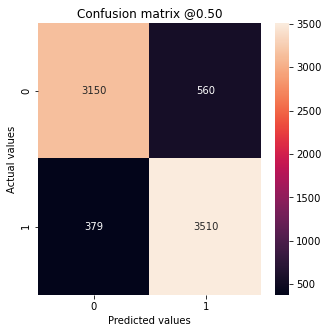

In [22]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [23]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      3710
           1       0.86      0.90      0.88      3889

    accuracy                           0.88      7599
   macro avg       0.88      0.88      0.88      7599
weighted avg       0.88      0.88      0.88      7599



In [24]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1_tfidf)

F1: 0.88


In [25]:
# Use predict_proba(X)[:, 1] to extract the probability that samples belong to the bullying class.
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf[:, 1])
print('AUC: %.2f' % auc_tfidf)

AUC: 0.95


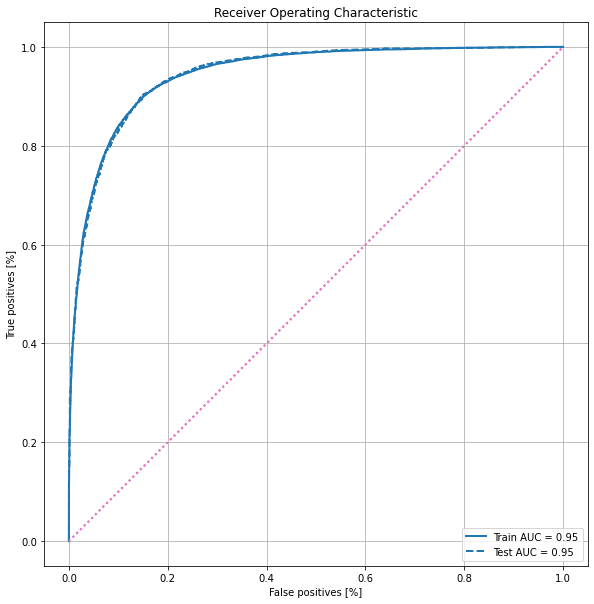

In [26]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf[:, 1], color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf[:, 1], color = colors[0], linestyle = '--')

In [27]:
import joblib
# save
joblib.dump(nb, "./nb.joblib")

['./nb.joblib']

In [29]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
import pickle
pickle.dump(nb, open('nb.pkl','wb'))